### Imports

In [12]:
import pennylane as qml
from pennylane import numpy as np
from numpy import kron as k
from numpy import pi
import networkx as nx
import matplotlib.pyplot as plt
import warnings
import itertools as it
from pennylane import qaoa
import pandas as pd
import random
from scipy.optimize import minimize

warnings.filterwarnings('ignore')
np.set_printoptions(threshold=np.inf, precision=3, suppress=False, linewidth=200)

### Multi-Constraint Generator

In [13]:

def generate_random_constraints(num_constraints, n_vars, minNumFeas, rhs):
    constraints = []
    for _ in range(num_constraints):
        while True:
            # Generate random coefficients for each variable
            coefficients = [random.randint(-10, 10) for _ in range(n_vars)]
            
            # Create the constraint string
            constraint_lhs = ' + '.join([f'{coefficients[i]}*x{i}' for i in range(n_vars)])
            constraint = f"{constraint_lhs} == {rhs}"
            
            # Check if there are at least two feasible solutions
            feasible_solutions = set()
            for bitstring in it.product([0, 1], repeat=n_vars):
                var_dict = {f'x{i}': bitstring[i] for i in range(n_vars)}
                if eval(constraint_lhs, {}, var_dict) == rhs:
                    feasible_solutions.add(tuple(bitstring))
                if len(feasible_solutions) >= minNumFeas:
                    constraints.append(constraint)
                    break
            if len(feasible_solutions) >= minNumFeas:
                break
    return constraints

def generate_truth_table(constraints, n_vars, yesPrintTTable):
    num_constraints = len(constraints)
    total_vars = n_vars + num_constraints  # Original vars + ancillae + alternating ancilla
    
    # Create all possible bitstrings for n_vars + ancillae + alternating ancilla
    bitstrings = list(it.product([0, 1], repeat=total_vars))
    
    # Prepare to store the truth table
    truth_table = []
    outcomes = []
    
    for bitstring in bitstrings:
        # Split bitstring into original vars, ancillae, and alternating ancilla
        original_vars = bitstring[:n_vars]
        ancillae = bitstring[n_vars:n_vars + num_constraints]
        alternating_ancilla = bitstring[-1]
        
        # Check if all constraints are satisfied
        constraints_satisfied = []
        for i, constraint in enumerate(constraints):
            constraint_lhs, constraint_rhs = constraint.split('==')
            constraint_rhs = int(constraint_rhs.strip())
            var_dict = {f'x{i}': original_vars[i] for i in range(n_vars)}
            eval_lhs = eval(constraint_lhs, {}, var_dict)
            is_satisfied = (eval_lhs == constraint_rhs)
            constraints_satisfied.append(is_satisfied)
        
        # Determine the overall outcome based on constraints and ancillae
        overall_satisfied = all(constraints_satisfied)
        outcome = 0 if (overall_satisfied and alternating_ancilla == 0) or (not overall_satisfied and alternating_ancilla == 1) else 1
        truth_table.append(list(original_vars) + list(ancillae) + [alternating_ancilla] + [outcome])
        outcomes.append(outcome)
    
    if yesPrintTTable:
        print("Truth table (original_vars + ancillae + alternating_ancilla + outcome):")
        for row in truth_table:
            print(row)
    
    return np.array(truth_table), outcomes


def eigen_constraint_to_matrix(outcomes):
    outcomesMat = np.diag(outcomes)
    penMat = qml.pauli_decompose(outcomesMat)
    return penMat


### Constraint Input

In [14]:
# Example usage
num_constraints = 2
n_vars = 2
n = n_vars + num_constraints   # Adding num_constraints ancillae and one final alternating ancilla
minNumFeas = 2
rhs = 1

# Generate constraints
constraints = generate_random_constraints(num_constraints, n_vars, minNumFeas, rhs)
print("Generated Constraints:", constraints)

yesPrintTTable = False
truth_table, outcomes = generate_truth_table(constraints, n_vars, yesPrintTTable)

# Create the cost matrix
costMat = np.diag(outcomes)
costH = qml.pauli_decompose(costMat, hide_identity=True)
print(np.real(qml.matrix(costH)))

# Determine feasible states
feasible_states = []
for i in range(2**n):
    bitstring = f'{i:0{n}b}'
    if (costMat[i, i] == 0 and all(bit == '0' for bit in bitstring[n_vars:n_vars + num_constraints]) and bitstring[-1] == '0'):
        feasible_states.append(f'|{bitstring}>')

# Calculate eigenvalues and optimal states
eigvals = np.real(np.diag(costMat))
opt_val = min([eigvals[int(s[1:-1], 2)] for s in feasible_states])
opt_states = [f'|{i:0{n}b}>' for i in range(2**n) if eigvals[i] == opt_val]

print(f'Minimum value: {min(eigvals)}')
print(f'Feasible states: {feasible_states}')
print(f'Optimal value: {opt_val}')
print(f'Optimal states: {opt_states}')

print('Eigenvalues (cut values) of the cost Hamiltonian:')
for i in range(2**n):
    print(f'|{i:0{n}b}>: {eigvals[i]}')


Generated Constraints: ['1*x0 + 0*x1 == 1', '0*x0 + 1*x1 == 1']
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Minimum value: 0
Feasible states: ['|1100>']
Optimal value: 0
Optimal states: ['|0001>', '|0011>', '|0101>', '|0111>', 

### ma-QAOA Functions

In [15]:
dev = qml.device('default.qubit', wires=n)
dev2 = qml.device('default.qubit', wires=n, shots=1000)


def qaoa_qubo(params, C_qubo, p=1, ma=True):
    n_ops = len(C_qubo.ops) - 1 
    coeffs, ops = C_qubo.terms()

    if ma:
        gamma = params[:, :n_ops]
        beta = params[:, n_ops:]
    if not ma:
        gamma = np.array([params[:, 0] for _ in range(n_ops)]).T
        beta = np.array([params[:, 1] for _ in range(n)]).T

    # Initial state
    for i in range(n):
        qml.Hadamard(wires=i)

    for q in range(p):
        # Cost unitary
        for idx, (w, op) in enumerate(zip(coeffs[:-1], ops[:-1])):
            qml.MultiRZ(w * gamma[q][idx], wires=op.wires)

        # Mixing unitary
        for i in range(n):
            # Custom combination of gates
            qml.RX(beta[q][i], wires=i)


@qml.qnode(dev)
def qubo_cost_fn(params, C_qubo, p=1, ma=True):
    qaoa_qubo(params, C_qubo, p, ma)
    return qml.expval(C_qubo)


@qml.qnode(dev2)
def qubo_calc_counts(params, C_qubo, ma=True):
    qaoa_qubo(params, C_qubo, ma=ma)
    return qml.counts(all_outcomes=True)


def optimize_qaoa_qubo(C_qubo, cost_fn, p=1, ma=False, maximize=False, starting_angles_from_qaoa=None):
    n_ops = len(C_qubo.ops) - 1
    # In case we know a good starting point
    if starting_angles_from_qaoa is not None:
        init_angles = starting_angles_from_qaoa
        # reshape angle to match multi-angle QAOA
        #init_angles = np.array([init_angles[:, 0] for _ in range(n_ops)] + [init_angles[:, 1] for _ in range(n)]).T
    else:
        if ma:
            init_angles = np.random.uniform(-2*np.pi, 2*np.pi, p*(n_ops + n), requires_grad=True).reshape(p, n_ops + n)
        else:
            init_angles = np.random.uniform(-2*np.pi, 2*np.pi, 2*p, requires_grad=True).reshape(p, 2)

    angles = init_angles

    # How close we want to get to the optimal value
    conv_tol = 1e-6
    # Maximum number of steps
    max_steps = 250

    # Create an optimizer
    #opt = qml.NesterovMomentumOptimizer(stepsize = 0.1)
    opt = qml.AdamOptimizer(stepsize = 0.1)

    if maximize:
        opt_mult = -1
    else:
        opt_mult = 1

    # Bookkeeping
    angless = [angles]
    costs = [opt_mult * cost_fn(angles, C_qubo, p, ma)]

    #print('Initial parameters:', angles)
    #print("Initial cost:", costs[0])

    for i in range(max_steps):
        # update the circuit parameters
        # print('------------------------------------------------------------')
        # print('Step:', i+1)
        # Optimize the circuit parameters and return the previous cost and the new parameters
        inputs, prev_cost = opt.step_and_cost(cost_fn, angless[-1], C_qubo, p, ma)
        angles = inputs[0]
        C_qubo = inputs[1]
        p = inputs[2]
        ma = inputs[3]

        angless.append(angles)
        new_cost = cost_fn(angles, C_qubo, p, ma)
        costs.append(opt_mult * new_cost)

        # print(f"Cost after step {i+1:5d}: {new_cost}")

        conv_prev = np.abs(new_cost - prev_cost)

        # if the difference between the previous cost and the current cost is less than the convergence tolerance
        if conv_prev <= conv_tol:
            break

    #print()
    #print(f"Optimized rotation angles: {np.round(angless[-1],4)}")

    return angless, costs

# Function to plot optimization progress
def plot_cost(costs_dict, opt_val, p):
    plt.figure(figsize=(9, 4.5))
    for label, costs in costs_dict.items():
        plt.plot(costs, label=label)
    plt.axhline(y=opt_val, color='r', linestyle='--', label='Optimal value')
    plt.xlabel('Iteration')
    plt.ylabel(r'$\langle C \rangle$')
    plt.title(f'Expectation value of the cost Hamiltonian $C$ for QAOA with depth {p}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def ma_probability_circuit(params, n, p, C, opt_states, ma = True, yesPrint = False):
    dev = qml.device('default.qubit', wires=n)

    @qml.qnode(dev)
    def circuit(params):
        qaoa_qubo(params, C, p, ma)
        return qml.probs(wires=range(n))

    # Get probabilities from the circuit
    probs = circuit(params)

    # Convert probabilities to dictionary with bitstrings as keys
    bitstrings = [format(i, '0' + str(n) + 'b') for i in range(2 ** n)]
    probs_dict = {bitstring: prob for bitstring, prob in zip(bitstrings, probs)}

    if (yesPrint):
        # Determine colors for the bars
        colors = ['red' if f'|{bitstring}>' in opt_states else 'skyblue' for bitstring in bitstrings]

        # Plot the probabilities
        plt.figure(figsize=(10, 4.5))
        bars = plt.bar(probs_dict.keys(), probs_dict.values(), color=colors, edgecolor='black')
        plt.xlabel('Bitstrings')
        plt.ylabel('Probabilities')
        plt.title(f'Probabilities of Optimal States After QAOA with Depth {p}')
        plt.xticks(rotation=90)
        plt.grid(axis='y', linestyle='--', linewidth=0.7)

        # Create custom legend
        from matplotlib.lines import Line2D
        custom_lines = [Line2D([0], [0], color='red', lw=4),
                        Line2D([0], [0], color='skyblue', lw=4)]
        plt.legend(custom_lines, ['Optimal States', 'Other States'])

        plt.show()
    

    return probs_dict


### Input

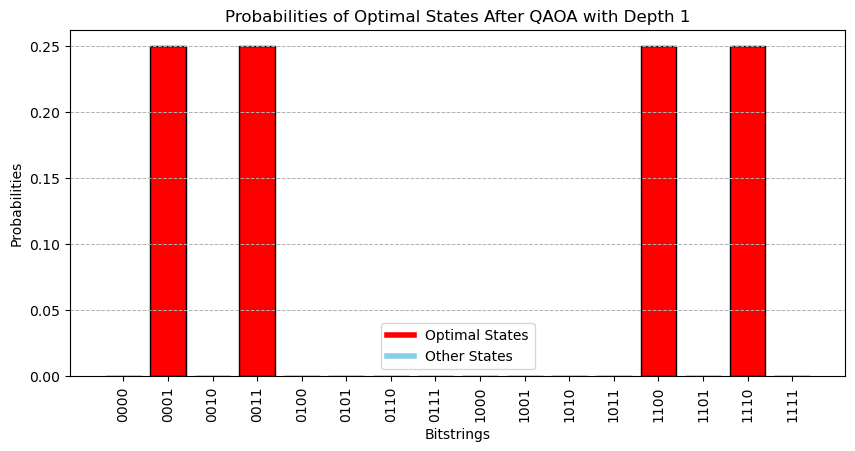

Best Angles for ma-QAOA: Gammas: [[6.281 2.549 6.282 6.273]], Betas: [[-4.706  1.571 -6.141  6.285]]


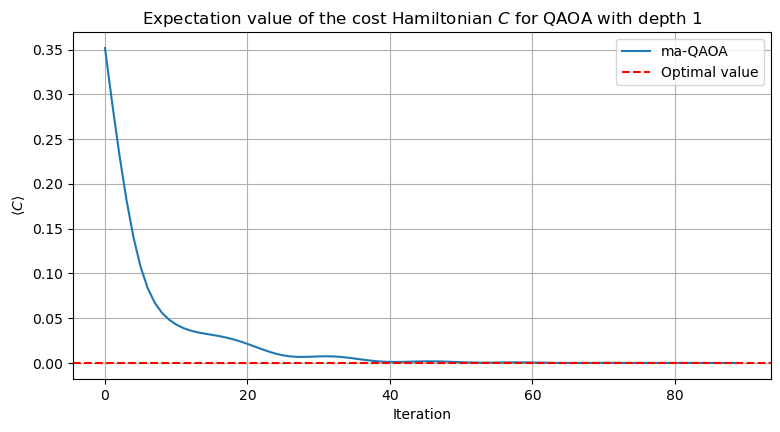

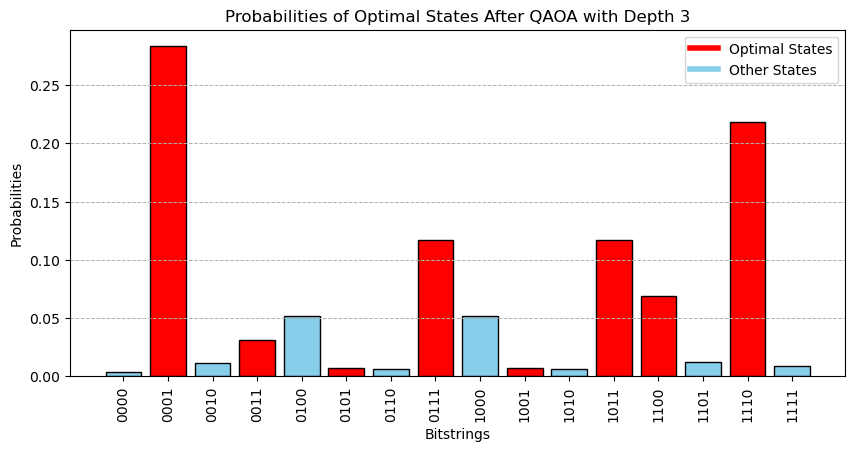

Best Angles for QAOA: Gammas: [[-2.072 -2.072 -2.072 -2.072]
 [-1.772 -1.772 -1.772 -1.772]
 [-5.257 -5.257 -5.257 -5.257]], Betas: [[ 5.425  5.425  5.425  5.425]
 [ 1.058  1.058  1.058  1.058]
 [-0.481 -0.481 -0.481 -0.481]]


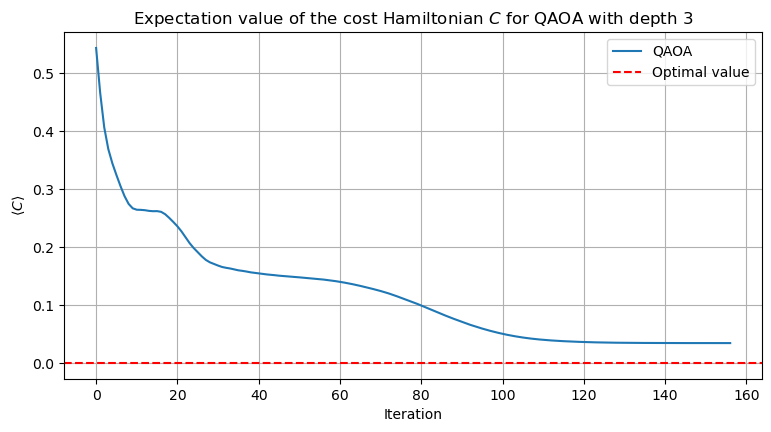

In [16]:
p_ma = 1
p_reg = 3
n_ops = len(costH) - 1

def extract_gammas_betas(params, ma, n_ops):
    if ma:
        gamma = params[:, :n_ops]
        beta = params[:, n_ops:]
    else:
        gamma = np.array([params[:, 0] for _ in range(n_ops)]).T
        beta = np.array([params[:, 1] for _ in range(n)]).T
    return gamma, beta

results = []

for method, p, ma in [("ma-QAOA", p_ma, True), ("QAOA", p_reg, False)]:
    bestCost = [1]
    bestAngles = []
    for i in range(10):  # Reduced loop to a single iteration
        opt_angles, opt_costs = optimize_qaoa_qubo(costH, qubo_cost_fn, p, ma=ma)
        
        if opt_costs[-1] < bestCost[-1]:
            bestCost = opt_costs
            bestAngles = opt_angles
    
    probs_dict = ma_probability_circuit(opt_angles[-1], n, p, costH, opt_states, ma=ma, yesPrint=True)
    gamma, beta = extract_gammas_betas(bestAngles[-1], ma, n_ops)
    #results.append({'Algorithm': method, 'p': p, 'Gammas': gamma.tolist(), 'Betas': beta.tolist(), 'Cost': bestCost[-1], 'Constraint': constraint})
    print(f"Best Angles for {method}: Gammas: {gamma}, Betas: {beta}")
    cost_dict = {method: bestCost}
    plot_cost(cost_dict, opt_val, p)
    
    """
    if (method == "QAOA" and p == 1):
        angles = np.array(bestAngles).reshape(-1, 2)
        opt_gamma = angles[:, 0]
        opt_beta = angles[:, 1]
        plot_param_landscape(opt_gamma, opt_beta, bestCost, costH, full=True)
        plot_param_landscape(opt_gamma, opt_beta, bestCost, costH, full=False)
    """
    
# Convert the results list to a DataFrame
#results_df = pd.DataFrame(results)

# Output the results
#print(results_df)

# Save the DataFrame to an Excel file
#results_df.to_excel('qaoa_results.xlsx', index=False)
